# WCWH Rollout Preparation
Working to get the beacons ready for their next adventure. 

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
sys.path.append('../')

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from src.visualization import visualize

from src.calibration import calibrate

import math
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

%load_ext autoreload
%autoreload 2

# Calibration
With access to higher-grade instruments, we start to look at the possibility of calibrating the sensors to get more-reliable results. We look at two primary ways of calibrating the beacons:

1. Constant/Offset
2. Linear Regression

## Experiment Details

### UTx000
1. Background 3 - **Used to Calibrate NO2 Sensors** 
 - **Start**: datetime(2020,12,30,12,40,0)
 - **End**: datetime(2020,12,31,12,40,0)
 - **Beacons**: [1,5,6,10,11,13,15,16,17,19,21,22,23,24,25,26,28,29,30,32,34,36,38,40,41,44,46,48]
2. Multi-Source 1 - **Used to Calibrate PM Number/Mass and CO2 Sensors**
 - **Start**: datetime(2021,1,5,12,0,0)
 - **End**: datetime(2021,1,6,10,40,0)
 - **Beacons**: [1,5,6,10,11,13,15,16,17,19,21,22,23,24,25,26,28,29,30,32,34,36,38,40,41,44,46,48]

### WCWH Ambassador Families
Here are the relevant notes from the calibration experiments:
1. Experiment 1
 - **Start**: datetime(2021,5,10,14,5,0)
 - **End**: datetime(2021,5,10,23,59,0)
 - **Beacons**: [1,2,4,5,6,7,10,11,12,13,14,15,16,19,21]
 - **Events**:
     - 14:15 - 14:25: CO2 cylinder open
     - 14:25 - 14:40: Candle burning
     - 14:40 - 14:50: CO2 cylinder open
     - 14:50 - 15:05: candle burning
 - **Notes**:
     - B26 added at 14:36
2. Experiment 2
 - **Start**: datetime(2021,5,11,16,30,0)
 - **End**: datetime(2021,5,11,17,30,0)
 - **Beacons**: [1,2,4,5,6,7,10,11,12,13,14,15,16,19,21]
 - **Events**:
     - 16:35 - 17:10: Candle and paper burning
     - 16:40 - 16:55: CO2 cylinder open
     
3. Experiment 3
 - **Start**: datetime(2021,5,21,9,23,0)
 - **End**: datetime(2021,5,21,12,23,0)
 - **Beacons**: [1,2,4,5,6,7,9,10,11,12,14,15,16,19,21,23,25,26,28,29]
 - **Events**:
     - 16:35 - 17:10: Candle and paper burning
     
4. Experiment 4
 - **Start**: datetime(2021,6,15,15,21,0)
 - **End**: datetime(2021,6,15,17,21,0)
 - **Beacons**: [1,2,4,5,6,7,9,10,11,12,14,15,16,19,21,23,25,26,28,29]
 - **Events**:
     - 15:22 - 16:02: Unoccupied
     - 16:03 - 16:16 CO2 cylinder open
     - 16:22: Paper Burning
     
### BEVO Beacons
 - **Beacons**: [1,5,6,7,9,10,11,15,16,19,21,24,25,26,29,30,34,36,38,44,46]

### Defining Calibration Object(s)
We use the `Calibration` class from the UTx000 Project.

#### Calibration Efforts for Ambassador (amb) Families

In [51]:
c_amb = calibrate.Calibration(datetime(2021,6,15,15,21,0),datetime(2021,6,15,17,21,0),"../data/",study="wcwh_pilot",study_suffix="wcwh_s21",
                          beacons=[1,5,6,7,10,11,15,16,19,21,24,25,26,29,30,34,36,38,44,46],resample_rate=3,moving="mean",window=5,verbose=False)

IMPORTING BEACON DATA
Error with file b10_2021-06-15.csv: Error tokenizing data. C error: Expected 19 fields in line 5, saw 24

IMPORTING REFERENCE DATA
File not found - ../data/calibration/no_06152021.csv


#### Calibration Efforts for UTx000 Post Calibration

In [48]:
c_ux = calibrate.Calibration(datetime(2021,1,12,10,0,0), datetime(2021,1,12,12,0,0),"../data/",study="utx000",study_suffix="ux_s20",
                          beacons=[1,5,6,7,10,11,15,16,19,21,24,25,26,29,30,34,36,38,44,46],resample_rate=3,moving="mean",window=5,verbose=False)#,ref_date=datetime(2021,1,15))

IMPORTING BEACON DATA
IMPORTING REFERENCE DATA


#### Calibration Test Object

In [43]:
c = calibrate.Calibration(datetime(2021,6,28,0,0,0), datetime(2021,6,29,23,0,0),"../data/",study="wcwh_pilot",study_suffix="wcwh_s21",
                          beacons=[1],resample_rate=3,moving="mean",window=5,verbose=False)#,ref_date=datetime(2021,1,15))

No file found - try providing a `timestamp` argument instead
IMPORTING BEACON DATA
IMPORTING REFERENCE DATA
File not found - ../data/calibration/pm_number_06292021.csv
File not found - ../data/calibration/pm_mass_06292021.csv
File not found - ../data/calibration/no2_06292021.csv
File not found - ../data/calibration/no_06292021.csv
File not found - ../data/calibration/co2_06292021.csv


## Inspection
Some simple functions to inspect measurements

In [5]:
#for var in ["co2","pm2p5_mass","tvoc","co","no2","temperature_c","rh","lux"]:
c.inspect_by_beacon_by_param("pm10_mass")

NameError: name 'c' is not defined

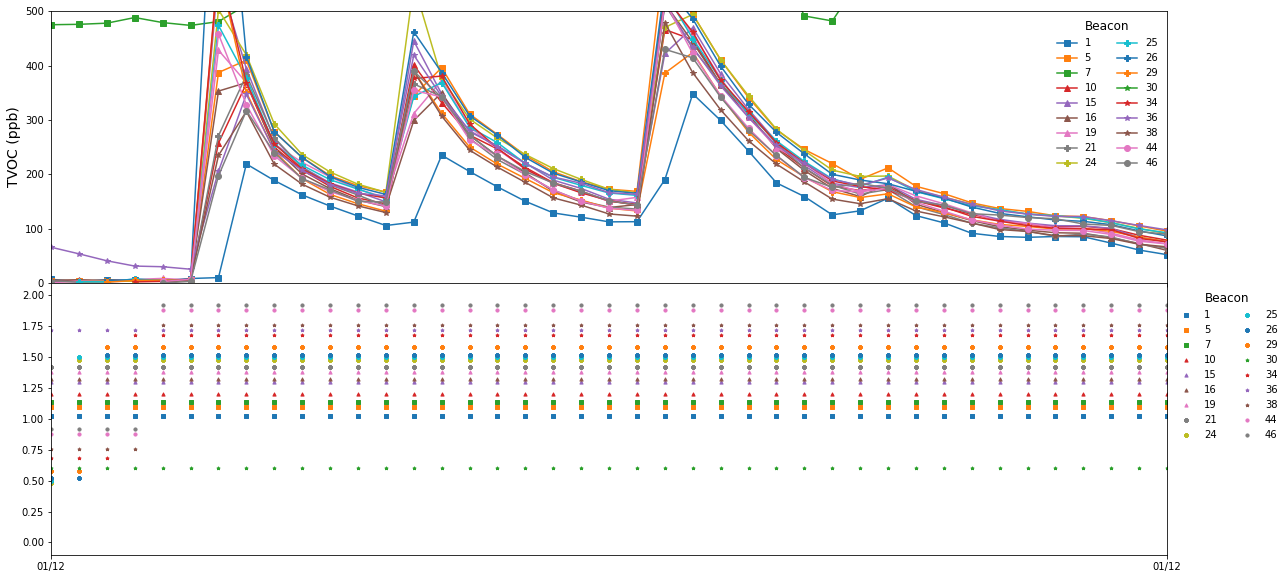

In [17]:
c_ux.inspect_timeseries("tvoc",ylimits=[0,500])

In [112]:
def comprehensive_ts(c_obj,r,c,species,save=False):
    """Plots comprehensive time series of the species against the min and max values"""
    temp = c_obj.beacon_data[["timestamp",species,"beacon"]].pivot(index="timestamp",columns="beacon",values="tvoc").dropna(axis=1)
    for col in temp.columns:
        offset = c_obj.offsets[species][c_obj.offsets[species].index == col]
        temp[col] -= offset["correction"].values

    temp["mean"] = temp.mean(axis=1)
    temp["min"] = temp.min(axis=1)
    temp["max"] = temp.max(axis=1)
    temp["t"] = (temp.index - temp.index[0]).total_seconds()/60
    fig, axes = plt.subplots(r,c,figsize=(c*4,r*4),sharex=True,sharey=True)
    for bb, ax in zip(temp.columns,axes.flat):
        if bb not in ["min","max","mean","t"]:
            ax.plot(temp["t"],temp[bb],color="black",linewidth=2,zorder=2)
            ax.fill_between(temp["t"],temp["min"],temp["max"],alpha=0.5,color="grey",zorder=1)
            ax.set_title(f"  Device {int(bb)}",y=0.85,pad=0,fontsize=13,loc="left",ha="left")
            ax.axis("off")
    
    axes[r-1,0].axis('on')
    for loc in ["top","right"]:
        axes[r-1,0].spines[loc].set_visible(False)
    ax.set_xticks(np.arange(0,125,30))
    plt.setp(axes[r-1,0].get_xticklabels(), ha="center", rotation=0, fontsize=16)
    plt.setp(axes[r-1,0].get_yticklabels(), ha="right", rotation=0, fontsize=16)
    axes[1,0].text(-2,7.5,f"Concentration ({visualize.get_pollutant_units(species)})",rotation=90,ha='right',va='center',fontsize=24)
    axes[r-1,int(c/2)].text(7.5,-2,f'Experiment Time (minutes)',ha='center',va='top',fontsize=24)

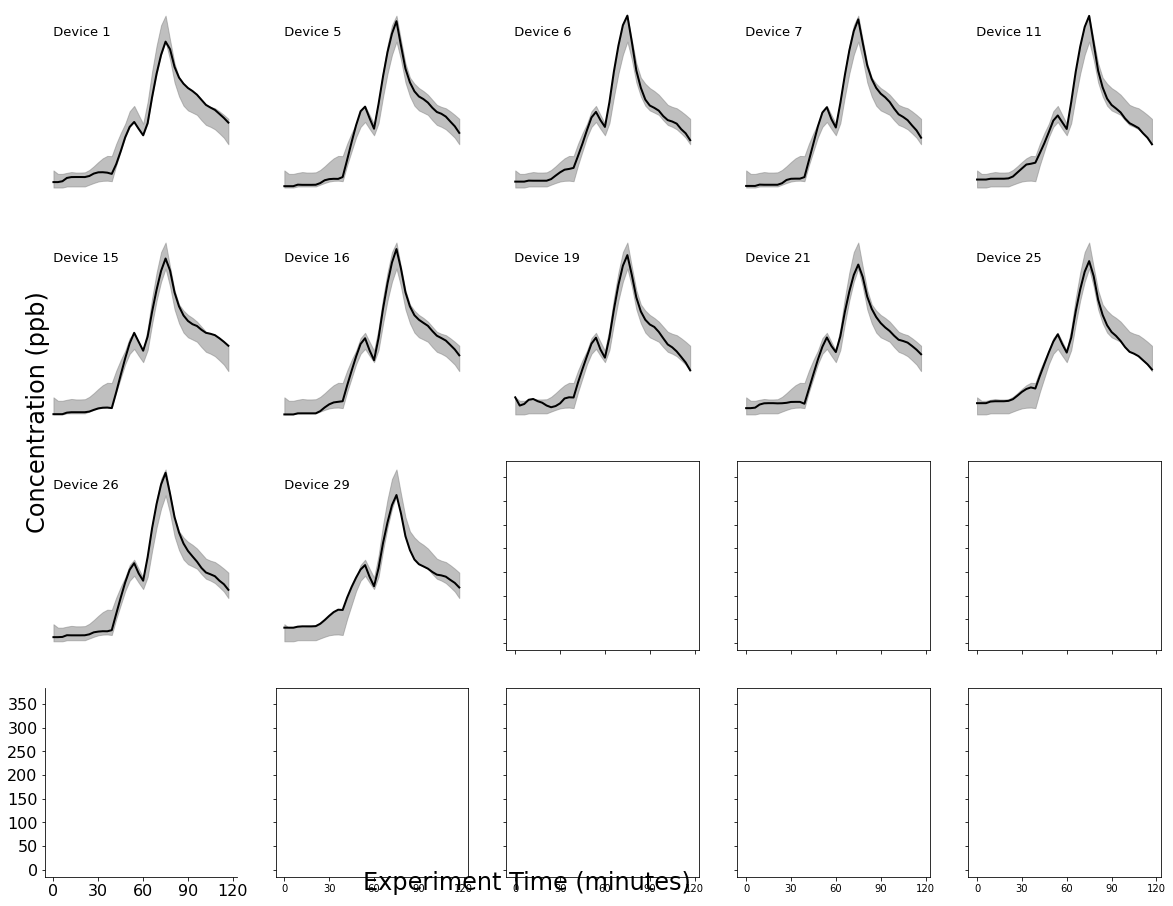

In [113]:
comprehensive_ts(c_amb,4,5,"tvoc")

## Diagnostics

### Non-Responsive Beacons
The ```get_reporting_beacons``` functions determines which of the beacons that was included in the calibration event are not shown in the following figures because of issues related to power, sensor connection, or VPN connection.

In [ ]:
missing, reporting = c.get_reporting_beacons("co")

## Comparison
As an initial exploration, we can also look into how the beacon measurements relate to the reference measurements. 

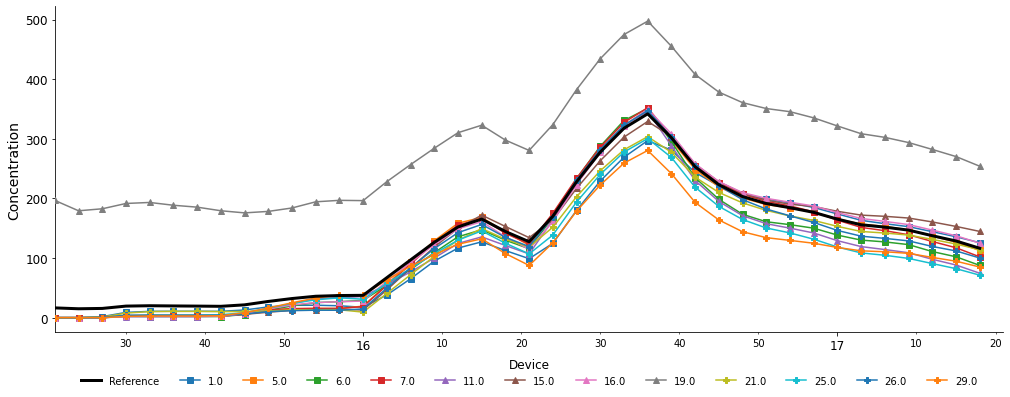

In [56]:
#c_ux.set_end_time(datetime(2021,1,5,14,0,0))

c_amb.compare_time_series("tvoc")

## Constant/Offset
For the `co` sensor, we do not have a reference monitor and therefore cannot accurately calibrate this sensor against other measurements. Instead, we can determine a constant offset assuming a clean, background concentration of 0 ppm. 

In [22]:
#c.offset("co")

## Linear Model

In [23]:
c_amb.linear_regression("co2",save_to_file=False,lap_filter=False)#,event=datetime(2021,6,15,16,22))
c_ux.linear_regression("co2",save_to_file=False,lap_filter=False)#,event=datetime(2021,6,15,16,22))

Beacon 1: Reference and beacon data are not the same length


In [13]:
c.show_linear_correction("co2",min_val=0)

NameError: name 'c' is not defined

In [15]:
def show_comprehensive_linear_corr(c_obj,r,c,species,save=False,**kwargs):
    """shows a subplot of all the correlation beacons"""
    fig, axes = plt.subplots(r,c,figsize=(c*4,r*4),sharex=True,sharey=True,gridspec_kw={"wspace":0.1})
    for bb, ax in zip(c_obj.beacons,axes.flat):
        beacon_by_bb = c_obj.beacon_data[c_obj.beacon_data["beacon"] == bb].set_index("timestamp")
        corrected_by_bb = beacon_by_bb.copy()
        corrected_by_bb[species] = beacon_by_bb[species] * c_obj.lms[species].loc[bb,"coefficient"] + c_obj.lms[species].loc[bb,"constant"]
        corrected_by_bb = corrected_by_bb.shift(c_obj.lms[species].loc[bb,"ts_shift"])[:len(c_obj.ref[species])]
        comb = corrected_by_bb.merge(right=c_obj.ref[species],left_index=True,right_index=True)
        ax.scatter(comb["concentration"],comb[species],color="black",zorder=2)
        max_val = np.nanmax(c_obj.ref[species]["concentration"])*1.1
        if "min_val" in kwargs.keys():
            min_val = kwargs["min_val"]
        else:
            min_val = 0
        # 1:1
        ax.plot([min_val,max_val],[min_val,max_val],color="firebrick",linewidth=2,zorder=1)
        # annotating
        lm_bb = c_obj.lms[species][c_obj.lms[species].index == bb]
        r2 = c_obj.lms[species]
        ax.set_title(f"  Device {int(bb)}\n  r$^2$ = {round(lm_bb['score'].values[0],3)}\n  y = {round(lm_bb['coefficient'].values[0],2)}x + {round(lm_bb['constant'].values[0],1)}",
                    y=0.85,pad=0,fontsize=13,loc="left",ha="left")
        # axis
        if "lim" in kwargs.keys():
            ax.set_xlim([min_val,kwargs["lim"]])
            ax.set_ylim([min_val,kwargs["lim"]])
            
        ax.axis('off')

    axes[r-1,0].axis('on')
    for loc in ["top","right"]:
        axes[r-1,0].spines[loc].set_visible(False)
    plt.setp(axes[r-1,0].get_xticklabels(), ha="left", rotation=-30, fontsize=16)
    plt.setp(axes[r-1,0].get_yticklabels(), ha="right", rotation=0, fontsize=16)
    axes[1,0].text(-1,7.5,f'BEVO Beacon {visualize.get_pollutant_label(species)} ({visualize.get_pollutant_units(species)})',rotation=90,ha='center',va='center',fontsize=24)
    axes[r-1,3].text(7.5,1,f'Reference {visualize.get_pollutant_label(species)} ({visualize.get_pollutant_units(species)})',ha='center',va='top',fontsize=24)

    if save:
        if "study" in kwargs.keys():
            study = "-"+kwargs["study"]
        else:
            study = ""
        plt.savefig(f"../reports/figures/beacon_summary/calibration-{species}-comprehensive_scatter{study}.pdf",bbox_inches="tight")
        
    plt.show()
    plt.close()

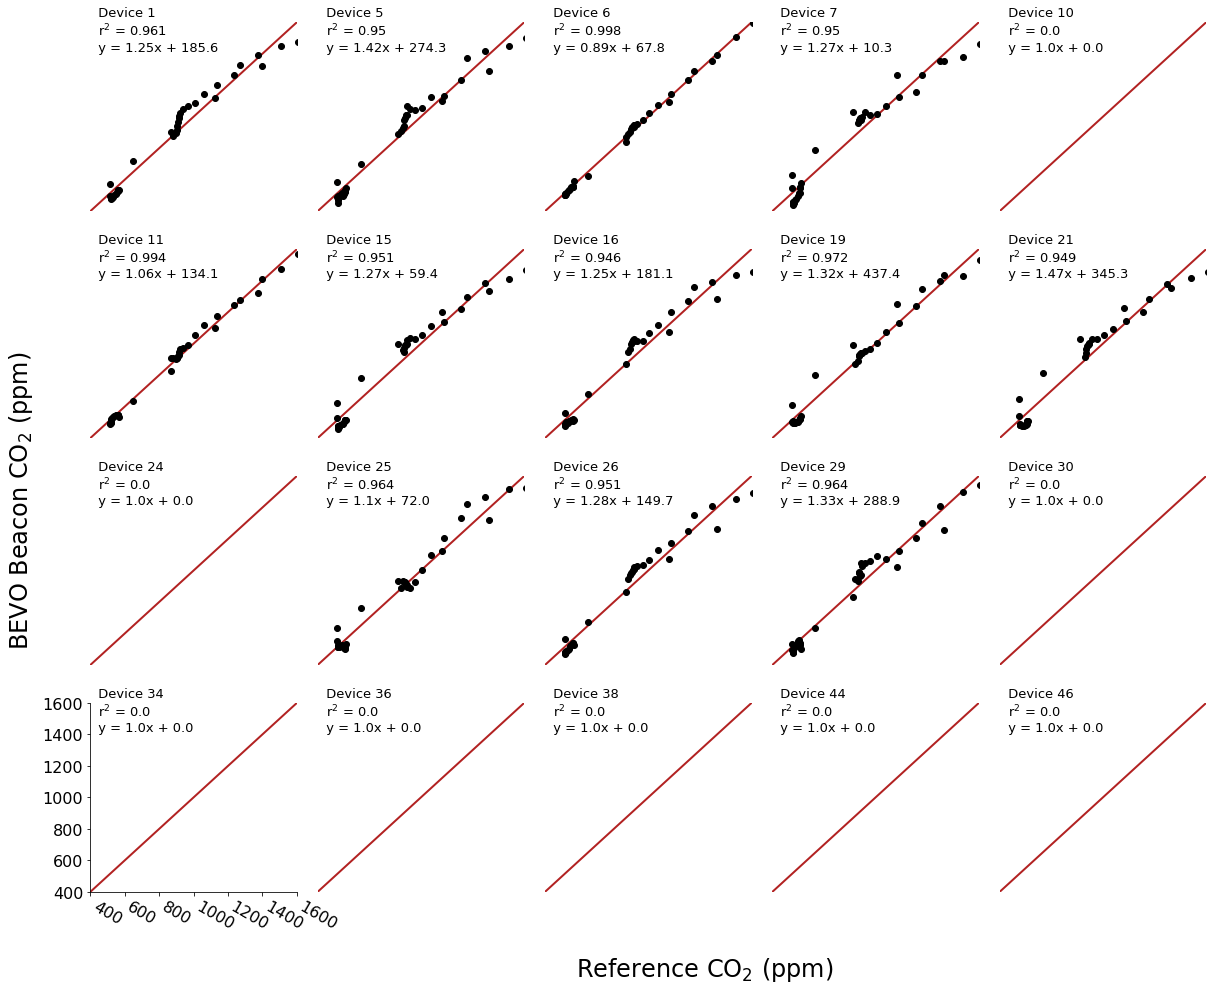

In [24]:
show_comprehensive_linear_corr(c_amb,4,5,"co2",min_val=400,lim=1600,save=False,study="wcwh_s21")

In [145]:
c_ux.lms["co2"]

,constant,coefficient,score,ts_shift
beacon,,,,
1,207.249982,0.907114,0.960815,-3
2,0.000000,1.000000,0.000000,0
3,0.000000,1.000000,0.000000,0
4,0.000000,1.000000,0.000000,0
5,271.764245,0.851330,0.949990,-3
6,0.000000,1.000000,0.000000,0
7,1894.380564,-2.091348,0.298831,-5
8,0.000000,1.000000,0.000000,0
9,0.000000,1.000000,0.000000,0


### Optimizing
We want to optimize the model fit by looking at a few tuning parameters:
* **Downsampling rate**: What happens if we downsample the raw data prior to fitting
* **Rolling Filter Type**: Mean vs Median
* **Window Size**: What is the ideal window size?
* **Weighting**: The peak values might be more important to consider

In [ ]:
species = "pm2p5_mass"
results = {}
params = {"resample_rate":[],"moving_filter":[],"window_size":[],"weighted":[]}
params_no = 1
for rs_rate in [1,2,5]:
    for moving in ["mean","median"]:
        for window in [3,5,7,9]:
            for weight in [False,True]:
                # outputting params
                print(f"Parameters:\n\tResample Rate:\t{rs_rate}\n\tMoving Filter:\t{moving}\n\tWindow Size:{window}\n\tWeighted:\t{weight}")
                for p, key in zip([rs_rate,moving,window,weight],params.keys()):
                    params[key].append(p)
                # calibration object
                c = calibrate.Calibration(datetime(2021,6,15,15,21,0),datetime(2021,6,15,17,21,0),
                          data_dir="../data/",study="wcwh_pilot",study_suffix="wcwh_s21",beacons=[1,2,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,21,23,25,26,28,29],
                          resample_rate=rs_rate,moving=moving,window=window,verbose=False)
                c.linear_regression(species,save_to_file=False,lap_filter=False,weight=weight)
                c.show_linear_correction(species,min_val=0)
                results[params_no] = pd.DataFrame(c.lms[species])
                params_no += 1
                
scores = []
for group, df in results.items():
    score = np.mean(df[df["score"] > 0]["score"])
    scores.append(score)
    
summarized_results = pd.DataFrame(params)
summarized_results["combined_score"] = scores
summarized_results.sort_values("combined_score",ascending=False,inplace=True)
summarized_results.to_csv(f"/Users/hagenfritz/Desktop/calibration_fit-{species}.csv")

In [ ]:
summarized_results.sort_values("combined_score",ascending=False)

In [ ]:
for i in range(len(results)+1):
    fig, ax = plt.subplots(figsize=(20,5))
    data = results[i+1]
    data = data[data["score"] > 0.1]
    ax.bar(data.index,data["score"],color="cornflowerblue",linewidth=2,edgecolor="black")
    # x-axis
    ax.set_xlim([0,30])
    ax.set_xticks(range(0,30))
    # y-axis
    # remainder
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    plt.show()
    plt.close()

#### Tabled: Cross-Validation
We can take a look at this later if need be, but it complicates the code a bit right now.

In [ ]:
b1 = c.beacon_data[c.beacon_data["beacon"] == 1]

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=2)
for tr_i, te_i in kf.split(b1):
    pass
    #print(tr_i)
    #print(te_i)